# The Fraser River Story
I want to look at a bunch of different regions and see how the Fraser behaves in them both seasonally and between different years. This is important because the Fraser River has unique chemical properties (like alkalinity). It's important to look not only at what regions it's in, but what depths it sits at and the seasonality of that. This will be relevant to things like spring bloom and bioproductivity and when the bloom happens in each region.

## General Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cmocean.cm as cm
from salishsea_tools import viz_tools
import matplotlib as mpl
import pandas as pd
import netCDF4 as nc
import shapely.geometry
from datetime import datetime
from matplotlib.dates import DateFormatter

In [2]:
bathy = xr.open_dataset('/home/sallen/MEOPAR/grid/bathymetry_202108.nc')

mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
# the mask is 1 where there is water, we want the opposite.  The meshmask has an extra dimension, hence the [0]
tmask = 1 - mesh.tmask[0]
area = ((1-tmask) * mesh.e1t[0] * mesh.e2t[0]).rename({'z':'depth', 'y':'gridY', 'x':'gridX'})[0]

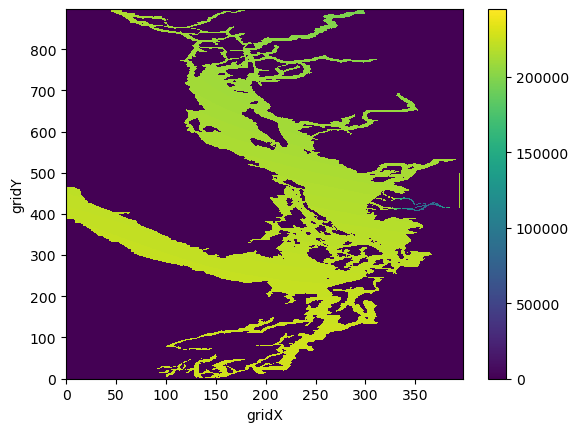

In [3]:
area.plot()

In [4]:
mesh = nc.Dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
bathy = nc.Dataset('/home/sallen/MEOPAR/grid/bathymetry_202108.nc')
mesh_mask_depth_var='gdept_0'

thalweg_file = '/home/sallen/MEOPAR/Tools/bathymetry/thalweg_working.txt'
thalweg_pts = np.loadtxt(thalweg_file, delimiter=' ', dtype=int)
mesh_mask_depth_var='gdept_0'
depth = mesh.variables[mesh_mask_depth_var][:]

## Field Imports and Transformations

In [5]:
# dimensions: gridY, gridX, time
sum_2023_mon = xr.open_dataset('/ocean/cdonaldson/research_runs/hindcast_auto/transformations/3d_hindcast_vol/SalishSeaCast_river_trace_day_avg_allR_00_40_res1M_{}0101_{}1231_e3t_3d_vol_e3t_depsum_vol.nc'.format(2023, 2023))
sum_2022_mon = xr.open_dataset('/ocean/cdonaldson/research_runs/hindcast_auto/transformations/3d_hindcast_vol/SalishSeaCast_river_trace_day_avg_allR_00_40_res1M_{}0101_{}1231_e3t_3d_vol_e3t_depsum_vol.nc'.format(2022, 2022))
sum_2021_mon = xr.open_dataset('/ocean/cdonaldson/research_runs/hindcast_auto/transformations/3d_hindcast_vol/SalishSeaCast_river_trace_day_avg_allR_00_40_res1M_{}0101_{}1231_e3t_3d_vol_e3t_depsum_vol.nc'.format(2021, 2021))
sum_2020_mon = xr.open_dataset('/ocean/cdonaldson/research_runs/hindcast_auto/transformations/3d_hindcast_vol/SalishSeaCast_river_trace_day_avg_allR_00_40_res1M_{}0101_{}1231_e3t_3d_vol_e3t_depsum_vol.nc'.format(2020, 2020))
sum_2019_mon = xr.open_dataset('/ocean/cdonaldson/research_runs/hindcast_auto/transformations/3d_hindcast_vol/SalishSeaCast_river_trace_day_avg_allR_00_40_res1M_{}0101_{}1231_e3t_3d_vol_e3t_depsum_vol.nc'.format(2019, 2019))

In [6]:
# dimensions: gridY, gridX, time
sum_2023 = xr.open_dataset('/ocean/cdonaldson/research_runs/hindcast_auto/transformations/3d_hindcast_vol/SalishSeaCast_river_trace_day_avg_allR_00_40_{}0101_{}1231_e3t_3d_vol_e3t_depsum_vol.nc'.format(2023, 2023))
sum_2022 = xr.open_dataset('/ocean/cdonaldson/research_runs/hindcast_auto/transformations/3d_hindcast_vol/SalishSeaCast_river_trace_day_avg_allR_00_40_{}0101_{}1231_e3t_3d_vol_e3t_depsum_vol.nc'.format(2022, 2022))
sum_2021 = xr.open_dataset('/ocean/cdonaldson/research_runs/hindcast_auto/transformations/3d_hindcast_vol/SalishSeaCast_river_trace_day_avg_allR_00_40_{}0101_{}1231_e3t_3d_vol_e3t_depsum_vol.nc'.format(2021, 2021))
sum_2020 = xr.open_dataset('/ocean/cdonaldson/research_runs/hindcast_auto/transformations/3d_hindcast_vol/SalishSeaCast_river_trace_day_avg_allR_00_40_{}0101_{}1231_e3t_3d_vol_e3t_depsum_vol.nc'.format(2020, 2020))
sum_2019 = xr.open_dataset('/ocean/cdonaldson/research_runs/hindcast_auto/transformations/3d_hindcast_vol/SalishSeaCast_river_trace_day_avg_allR_00_40_{}0101_{}1231_e3t_3d_vol_e3t_depsum_vol.nc'.format(2019, 2019))

## Functions

In [7]:
year_lines = ['-', (0, (1, 1)), (5, (10, 3)), (0, (5, 1)), (0, (3, 1, 1, 1, 1, 1))]

In [8]:
def make_1d(ds, reg_list):
    all_1d = ds.isel(gridY=slice(reg_list[0][0], reg_list[0][1]), gridX=slice(reg_list[0][2], reg_list[0][3])).sum(dim='gridY').sum(dim='gridX')
    for region in reg_list[1:]:
        next = ds.isel(gridY=slice(region[0], region[1]), gridX=slice(region[2], region[3])).sum(dim='gridY').sum(dim='gridX')
        all_1d = all_1d + next

    return all_1d

In [9]:
def make_meters(ds, reg_list):
    all_1d = ds.isel(gridY=slice(reg_list[0][0], reg_list[0][1]), gridX=slice(reg_list[0][2], reg_list[0][3])).mean(dim='gridY').mean('gridX')
    for region in reg_list[1:]:
        next = ds.isel(gridY=slice(region[0], region[1]), gridX=slice(region[2], region[3])).mean(dim='gridY').mean('gridX')
        all_1d = all_1d + next

    return all_1d

In [10]:
def plot_box(ax, corn, colour):
    ax.plot([corn[2], corn[3], corn[3], corn[2], corn[2]], 
            [corn[0], corn[0], corn[1], corn[1], corn[0]], '-', color=colour)

In [11]:
def plot_river_years(riv_key):  # plots all years on top of each other to look at inter-annual comparisons
    fig, ax = plt.subplots(2, 1, figsize=(9, 6), sharex=True)
    fig.suptitle(riv_key)

    ax[0].plot(meters1_2019_mon['time'].dt.strftime('%m-%d'), meters1_2019_mon[riv_key], label='2019', linestyle=year_lines[0], color='k')
    ax[0].plot(meters1_2020_mon['time'].dt.strftime('%m-%d'), meters1_2020_mon[riv_key], label='2020', linestyle=year_lines[1], color='k')
    ax[0].plot(meters1_2021_mon['time'].dt.strftime('%m-%d'), meters1_2021_mon[riv_key], label='2021', linestyle=year_lines[2], color='k')
    ax[0].plot(meters1_2022_mon['time'].dt.strftime('%m-%d'), meters1_2022_mon[riv_key], label='2022', linestyle=year_lines[3], color='k')
    ax[0].plot(meters1_2023_mon['time'].dt.strftime('%m-%d'), meters1_2023_mon[riv_key], label='2023', linestyle=year_lines[4], color='k')
    ax[0].legend()
    ax[0].set_title('meters of freshwater')
    ax[0].set_ylabel(r'$m$')
    ax[0].grid(axis='y', color='#737373', linestyle=(0, (1, 10)))

    ax[1].plot(prop_2019_mon['time'].dt.strftime('%m-%d'), prop_2019_mon[riv_key], label='2019', linestyle=year_lines[0], color='k')
    ax[1].plot(prop_2020_mon['time'].dt.strftime('%m-%d'), prop_2020_mon[riv_key], label='2020', linestyle=year_lines[1], color='k')
    ax[1].plot(prop_2021_mon['time'].dt.strftime('%m-%d'), prop_2021_mon[riv_key], label='2021', linestyle=year_lines[2], color='k')
    ax[1].plot(prop_2022_mon['time'].dt.strftime('%m-%d'), prop_2022_mon[riv_key], label='2022', linestyle=year_lines[3], color='k')
    ax[1].plot(prop_2023_mon['time'].dt.strftime('%m-%d'), prop_2023_mon[riv_key], label='2023', linestyle=year_lines[4], color='k')
    ax[1].set_title('proportion of freshwater')
    ax[1].grid(axis='y', color='#737373', linestyle=(0, (1, 10)))

In [12]:
def plot_field_12_months_sum(p_var, cmap, ds, tmask, year, vol_mon):
    nrow = 3
    ncol = 4

    fname = '{}_all_domain_subset_daily_sum_y{}'.format(p_var, year)
    cmap.set_bad('gray')

    fig, ax = plt.subplots(nrow,ncol, figsize = (8.5, 11), sharex=True, sharey=True)

    for row in np.arange(nrow):
        for col in np.arange(ncol):
            time_idx = row * ncol + col
            salinity = np.ma.masked_array(ds[p_var][time_idx], mask=tmask[0])
            colours = ax[row,col].pcolormesh(salinity, vmin=0, cmap=cmap)
            dtime = pd.to_datetime(ds['time'].values[time_idx])
            ax[row,col].set_title('{} {}'.format(dtime.month_name(), dtime.year))
            viz_tools.set_aspect(ax[row,col]);

    cb = fig.colorbar(colours, ax=ax, label='{} [{}]'.format(p_var, vol_mon[p_var].units))

    # plt.savefig('/ocean/cdonaldson/MOAD/analysis-cassidy/notebooks/river_dye_trace/monthly_vis/hindcast_auto/mean/{}.png'.format(fname))

In [13]:
def plot_thalweg_12_months(year, ds, p_var, ymin, ymax, cmap):

    var_thals = []
    for time_idx in range(0,12):
        dep_thal, distance, var_thal = vis.load_thalweg(
                depth[0, ...], np.array(ds[p_var][time_idx]), bathy['nav_lon'][:], bathy['nav_lat'][:],
                thalweg_pts)
        var_thals = var_thals + [var_thal]
    var_thals_arr = np.array(var_thals)
    global_max = np.floor(var_thals_arr.max()/1000)*1000
    global_min = global_max/10
    
    fig, axs = plt.subplots(12, 1, figsize=(12, 35))
    jp = 0
    levels = np.linspace(global_min, round(global_max), 10)
    cont_max=global_max
    for month in range(1, 13):
        time_idx = month-1
        var_thal = var_thals[time_idx]
        var_plot = vis._fill_in_bathy(var_thal, mesh, thalweg_pts)
        colours = axs[jp].contourf(distance, dep_thal, var_plot, 
                                cmap=cmap, extend='both', zorder=-1, levels=levels)
        axs[jp].contour(distance, dep_thal, var_plot, levels, 
                                colors='black', zorder=0)
        vis._add_bathy_patch(
                distance, bathy['Bathymetry'][:], thalweg_pts, axs[jp], color='burlywood')
        cbar = fig.colorbar(colours, ax=axs[jp], label='{} [{}]'.format(p_var, ds[p_var].units))
        axs[jp].invert_yaxis()
        axs[jp].set_ylim(ymax, ymin)
        axs[jp].set_ylabel('Depth [m]');
        axs[jp].set_xlabel('Distance along thalweg [km]')
        dtime = pd.to_datetime(ds['time'].values[time_idx])
        axs[jp].set_title('{} {}'.format(dtime.month_name(), year))
        jp = jp + 1;
    fig.tight_layout();

In [14]:
def make_m_and_prop_mon(regions, river):
    total_area = make_1d(area, regions)

    dim1_2019_mon = make_1d(sum_2019_mon, regions)  # dim1 is the sum of all the water in the given regions. is 1d in time for each river
    dim1_2020_mon = make_1d(sum_2020_mon, regions)
    dim1_2021_mon = make_1d(sum_2021_mon, regions)
    dim1_2022_mon = make_1d(sum_2022_mon, regions)
    dim1_2023_mon = make_1d(sum_2023_mon, regions)
    dim1_all_mon = xr.concat([dim1_2019_mon, dim1_2020_mon, dim1_2021_mon, dim1_2022_mon, dim1_2023_mon], dim='time')

    meters1_all_mon = dim1_all_mon[river] / total_area

    totals_all_mon = dim1_all_mon.to_array().sum(dim="variable")
    prop_all_mon = dim1_all_mon[river] / totals_all_mon

    return meters1_all_mon, prop_all_mon

In [15]:
def make_m_and_prop(regions, river):
    total_area = make_1d(area, regions)

    dim1_2019 = make_1d(sum_2019, regions)  # dim1 is the sum of all the water in the given regions. is 1d in time for each river
    dim1_2020 = make_1d(sum_2020, regions)
    dim1_2021 = make_1d(sum_2021, regions)
    dim1_2022 = make_1d(sum_2022, regions)
    dim1_2023 = make_1d(sum_2023, regions)
    dim1_all = xr.concat([dim1_2019, dim1_2020, dim1_2021, dim1_2022, dim1_2023], dim='time')

    meters1_all = dim1_all[river] / total_area

    totals_all = dim1_all.to_array().sum(dim="variable")
    prop_all = dim1_all[river] / totals_all

    return meters1_all, prop_all

## Regional Meters and Proportion

In [16]:
def plot_poly(ax, poly, color):
    x,y = poly.exterior.xy
    ax.plot(x,y,color=color)

In [17]:
def make_poly4corn(y0, y1, x0, x1):
    return shapely.geometry.Polygon([(x0, y0), (x1, y0), (x1, y1), (x0, y1)])

In [18]:
tablist_nogrey = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:olive', 'tab:cyan']

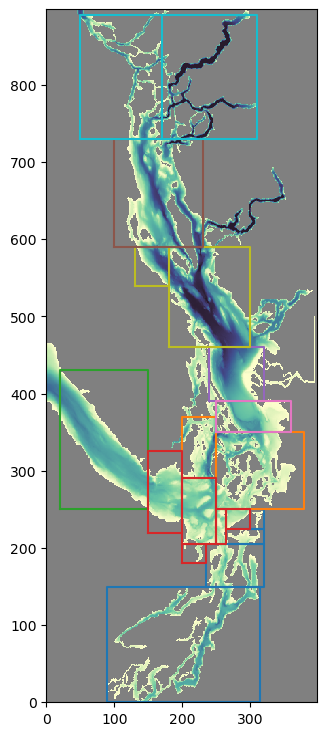

In [19]:
## my boxes
fig, ax = plt.subplots(1, 1, figsize=(5, 9))
mycmap = cm.deep
mycmap.set_bad('grey')
ax.pcolormesh(bathy['Bathymetry'], cmap=mycmap)
viz_tools.set_aspect(ax);

## Puget Sound
PS_main = [0, 150, 90, 315]
plot_box(ax, PS_main, tablist_nogrey[0])
PS_AIWB = [150, 205, 235, 320]
plot_box(ax, PS_AIWB, tablist_nogrey[0])
PS_WB = [205, 225, 265, 320]
plot_box(ax, PS_WB, tablist_nogrey[0])
PS_DP = [225, 250, 300, 320]
plot_box(ax, PS_DP, tablist_nogrey[0])

# puget_sound_poly = shapely.geometry.Polygon([(85, 1), (220, 1), (325, 120), (325, 255), (310, 255), (240, 200), (235, 170), (100, 90)])
# plot_poly(ax, puget_sound_poly, 'k')

## Mixing Region
mixing_region1 = [290, 370, 200, 250]
plot_box(ax, mixing_region1, tablist_nogrey[1])
mixing_region2 = [250, 350, 250, 380]
plot_box(ax, mixing_region2, tablist_nogrey[1])

# mixing_region_poly = shapely.geometry.Polygon([(200, 300), (340, 245), (390, 330), (200, 350)])
# plot_poly(ax, mixing_region_poly, 'b')

## Juan de Fuca
JdF1 = [250, 430, 20, 150]
plot_box(ax, JdF1, tablist_nogrey[2])  ## West
JdF2 = [220, 325, 150, 200]
plot_box(ax, JdF2, tablist_nogrey[3])
JdF3 = [205, 290, 200, 250]
plot_box(ax, JdF3, tablist_nogrey[3])
JdF4 = [180, 205, 200, 235]
plot_box(ax, JdF4, tablist_nogrey[3])
JdF5 = [205, 250, 250, 265]
plot_box(ax, JdF5, tablist_nogrey[3])
JdF6 = [225, 250, 265, 300]
plot_box(ax, JdF6, tablist_nogrey[3])

## Fraser River Plume
Fraser_plume = [390, 460, 240, 320]
plot_box(ax, Fraser_plume, tablist_nogrey[4])

## Strait of Georgia
SoG_south = [350, 390, 250, 360]
plot_box(ax, SoG_south, tablist_nogrey[6])
SoG_center1 = [460, 590, 180, 300]
plot_box(ax, SoG_center1, tablist_nogrey[7])
SoG_center2 = [540, 590, 130, 180]
plot_box(ax, SoG_center2, tablist_nogrey[7])
SoG_north = [590, 730, 100, 230]
plot_box(ax, SoG_north, tablist_nogrey[5])

## Northern Sounds
sounds = [730, 890, 170, 310]
plot_box(ax, sounds, tablist_nogrey[8])
straits = [730, 890, 50, 170]
plot_box(ax, straits, tablist_nogrey[8])

PS_all = [PS_main, PS_AIWB, PS_WB, PS_DP]
MR_all = [mixing_region1, mixing_region2]
JdFE_all = [JdF2, JdF3, JdF4, JdF5, JdF6]
JdFW_all = [JdF1]
FRP_all = [Fraser_plume]
SoGN_all = [SoG_north]
SoGS_all = [SoG_south]
SoGC_all = [SoG_center1, SoG_center2]
SaS_all = [sounds, straits]

In [20]:
tablist_nogrey[2]

'tab:green'

Regions have been loosely defined based on the bathymetry of the Salish Sea and the proximity to the Fraser River Plume.

Puget Sound is a contained geographical region comprised of multiple branching pathways, with a main entryway and two (?) smaller auxillary entry points.

The Mixing Region around Haro and Rosario Strait has been shown to have high amounts of mixing as water is pumped through (look at Susan and Camryn's work). It is more difficult for water to move through this mixing region without becoming more homogenized.

The Strait of Juan de Fuca has been split into two different regions: JdF East and JdF West.

## Create Datasets to Save (comment after first use)

In [21]:
# meters_PS_mon, prop_PS_mon = make_m_and_prop_mon(PS_all, 'fraser_river')
# meters_MR_mon, prop_MR_mon = make_m_and_prop_mon(MR_all, 'fraser_river')
# meters_JdFE_mon, prop_JdFE_mon = make_m_and_prop_mon(JdFE_all, 'fraser_river')
# meters_JdFW_mon, prop_JdFW_mon = make_m_and_prop_mon(JdFW_all, 'fraser_river')
# meters_FRP_mon, prop_FRP_mon = make_m_and_prop_mon(FRP_all, 'fraser_river')
# meters_SoGN_mon, prop_SoGN_mon = make_m_and_prop_mon(SoGN_all, 'fraser_river')
# meters_SoGS_mon, prop_SoGS_mon = make_m_and_prop_mon(SoGS_all, 'fraser_river')
# meters_SoGC_mon, prop_SoGC_mon = make_m_and_prop_mon(SoGC_all, 'fraser_river')
# meters_SaS_mon, prop_SaS_mon = make_m_and_prop_mon(SaS_all, 'fraser_river')

In [22]:
# meters_PS, prop_PS = make_m_and_prop(PS_all, 'fraser_river')
# meters_MR, prop_MR = make_m_and_prop(MR_all, 'fraser_river')
# meters_JdFE, prop_JdFE = make_m_and_prop(JdFE_all, 'fraser_river')
# meters_JdFW, prop_JdFW = make_m_and_prop(JdFW_all, 'fraser_river')
# meters_FRP, prop_FRP = make_m_and_prop(FRP_all, 'fraser_river')
# meters_SoGN, prop_SoGN = make_m_and_prop(SoGN_all, 'fraser_river')
# meters_SoGS, prop_SoGS = make_m_and_prop(SoGS_all, 'fraser_river')
# meters_SoGC, prop_SoGC = make_m_and_prop(SoGC_all, 'fraser_river')
# meters_SaS, prop_SaS = make_m_and_prop(SaS_all, 'fraser_river')

In [23]:
# meters_ds_int_mon = xr.Dataset({
#     'PS': meters_PS_mon,
#     'MR': meters_MR_mon,
#     'JdFE': meters_JdFE_mon,
#     'JdFW': meters_JdFW_mon,
#     'FRP': meters_FRP_mon,
#     'SoGN': meters_SoGN_mon,
#     'SoGS': meters_SoGS_mon,
#     'SoGC': meters_SoGC_mon,
#     'SaS': meters_SaS_mon
# })
# formatted_time = meters_ds_int_mon['time'].dt.strftime('%m-%d-%Y')
# meters_ds_mon = xr.Dataset()
# for var in meters_ds_int_mon.data_vars:
#     meters_ds_mon[var] = xr.DataArray(
#         meters_ds_int_mon[var].values,
#         coords={'time': formatted_time},
#         dims=meters_ds_int_mon[var].dims,
#         name=meters_ds_int_mon[var].name,
#         attrs=meters_ds_int_mon[var].attrs
#     )
# meters_ds_mon.attrs = meters_ds_int_mon.attrs

# prop_ds_int_mon = xr.Dataset({
#     'PS': prop_PS_mon,
#     'MR': prop_MR_mon,
#     'JdFE': prop_JdFE_mon,
#     'JdFW': prop_JdFW_mon,
#     'FRP': prop_FRP_mon,
#     'SoGN': prop_SoGN_mon,
#     'SoGS': prop_SoGS_mon,
#     'SoGC': prop_SoGC_mon,
#     'SaS': prop_SaS_mon
# })
# formatted_time = prop_ds_int_mon['time'].dt.strftime('%m-%d-%Y')
# prop_ds_mon = xr.Dataset()
# for var in prop_ds_int_mon.data_vars:
#     prop_ds_mon[var] = xr.DataArray(
#         prop_ds_int_mon[var].values,
#         coords={'time': formatted_time},
#         dims=prop_ds_int_mon[var].dims,
#         name=prop_ds_int_mon[var].name,
#         attrs=prop_ds_int_mon[var].attrs
#     )
# prop_ds_mon.attrs = prop_ds_int_mon.attrs

# meters_ds_int_mon.to_netcdf('fraser_monthly_m_freshwater.nc')
# prop_ds_int_mon.to_netcdf('fraser_monthly_prop_freshwater.nc')

In [24]:
meters_ds_mon = xr.open_dataset('fraser_monthly_m_freshwater.nc')
prop_ds_mon = xr.open_dataset('fraser_monthly_prop_freshwater.nc')

In [25]:
# meters_ds_int = xr.Dataset({
#     'PS': meters_PS,
#     'MR': meters_MR,
#     'JdFE': meters_JdFE,
#     'JdFW': meters_JdFW,
#     'FRP': meters_FRP,
#     'SoGN': meters_SoGN,
#     'SoGS': meters_SoGS,
#     'SoGC': meters_SoGC,
#     'SaS': meters_SaS
# })
# formatted_time = meters_ds_int['time'].dt.strftime('%m-%d-%Y')
# meters_ds = xr.Dataset()
# for var in meters_ds_int.data_vars:
#     meters_ds[var] = xr.DataArray(
#         meters_ds_int[var].values,
#         coords={'time': formatted_time},
#         dims=meters_ds_int[var].dims,
#         name=meters_ds_int[var].name,
#         attrs=meters_ds_int[var].attrs
#     )
# meters_ds.attrs = meters_ds_int.attrs

# prop_ds_int = xr.Dataset({
#     'PS': prop_PS,
#     'MR': prop_MR,
#     'JdFE': prop_JdFE,
#     'JdFW': prop_JdFW,
#     'FRP': prop_FRP,
#     'SoGN': prop_SoGN,
#     'SoGS': prop_SoGS,
#     'SoGC': prop_SoGC,
#     'SaS': prop_SaS
# })
# formatted_time = prop_ds_int['time'].dt.strftime('%m-%d-%Y')
# prop_ds = xr.Dataset()
# for var in prop_ds_int.data_vars:
#     prop_ds[var] = xr.DataArray(
#         prop_ds_int[var].values,
#         coords={'time': formatted_time},
#         dims=prop_ds_int[var].dims,
#         name=prop_ds_int[var].name,
#         attrs=prop_ds_int[var].attrs
#     )
# prop_ds.attrs = prop_ds_int.attrs

# meters_ds_int.to_netcdf('fraser_daily_m_freshwater.nc')
# prop_ds_int.to_netcdf('fraser_daily_prop_freshwater.nc')

In [26]:
meters_ds = xr.open_dataset('fraser_daily_m_freshwater.nc')
prop_ds = xr.open_dataset('fraser_daily_prop_freshwater.nc')

In [27]:
regions_list = list(meters_ds.keys())
regions_list

['PS', 'MR', 'JdFE', 'JdFW', 'FRP', 'SoGN', 'SoGS', 'SoGC', 'SaS']

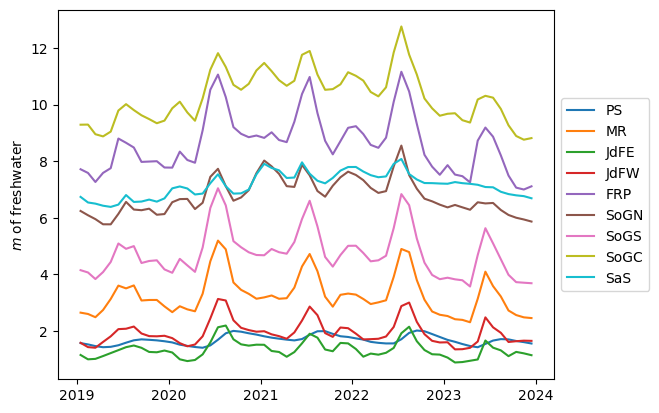

In [28]:
for idx in np.arange(len(regions_list)):
    region = regions_list[idx]
    plt.plot(meters_ds_mon['time'], meters_ds_mon[region], label=region, c=tablist_nogrey[idx])
plt.ylabel(r'$m$ of freshwater')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

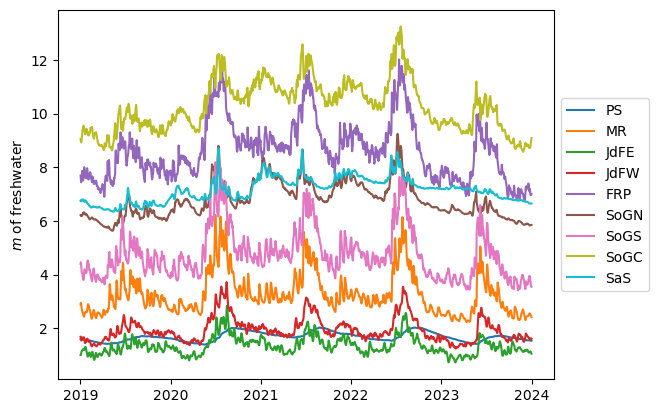

In [29]:
for idx in np.arange(len(regions_list)):
    region = regions_list[idx]
    plt.plot(meters_ds['time'], meters_ds[region], label=region, c=tablist_nogrey[idx])
plt.ylabel(r'$m$ of freshwater')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

PS: The Fraser River signal shows very little daily variation in Puget Sound, making it an interesting region to look into further. Is this because of the availible entry points into Puget Sound? I should look at a cross section across the boundary of puget sound and show monthly averages there of where Fraser River water is. The "peaks" in PS signal also have very long tails. It seems like the signal overall is very damped. As shown later, the maximum value in 2023 due to freshet doesn't exceed the value on the 1st of January at the tail end of 2022. This will lead well into the PS story, but the years 2019 and 2023 are low when compared to 2020, 2021, and 2022 which all have very similar max values. The lows also tend to have similar max values, but this is a small sample size. I want to look into each year's lowest point as well.

MR: This signal looks to vollow the daily FR flow plot very closely. It has lower years in 2019 and 2023, with 2023 attenuating faster compared to others years just like the FR itself does. The signal follows that of SoGS very closely, just at lower amplitude, which makes sense as they are right next to each other but MR is farther away from SoGS.

JdFE: This signal is the lowest of all in terms of meters of freshwater. I wouldn't have expected this, as I would have thought there would be more FR water going through JdF than through Johnstone Strait in the model and that this would cause more FR water to be present in the region. Maybe though, it has something to do with JdF not being very stagnant whearas the northern regions are more stagnant. It would be interesting to go back to the spin up of the model run for a few key regions and see what the residence time of Fraser River water is in them.

JdFW: Similar story here, although I think I have mis-labled JdFE and JdFW, but I need to look into this more... I would imagine the Western section of JdF would have less Fraser River water than the Eastern. I need to troubleshoot this more, or come up with an idea for why this would be happening.

FRP: This very closely follows the Fraser River outflow, but isn't the highest value. I imagine it's because there's a lot of Fraser River water sitting deep in the Central SoG

SoGN: This has a higher baseline value, and the relative fluctuations of the signal are lower compared to other signals that seem to be influenced by the surface water in the region.

SoGs: already talked about this a bit with relation to the MR.

SoGC: This signal has the highest amoubn



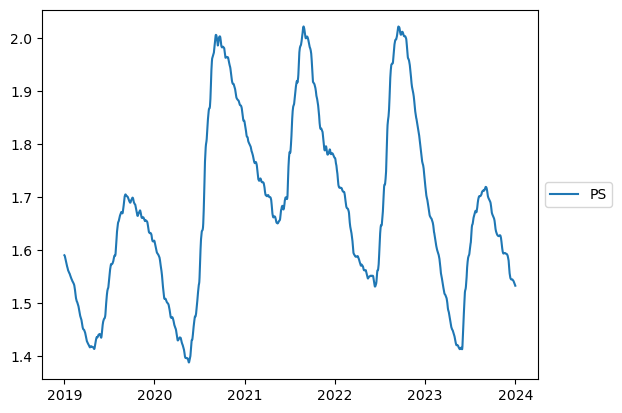

In [30]:
plt.plot(meters_ds['time'], meters_ds['PS'], label='PS', c=tablist_nogrey[0])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [31]:
# meters_2019 = meters_ds.sel(time=slice('01-15-2019', '12-15-2019'))
# max_values = {var: meters_2019[var].max().item() for var in meters_2019.data_vars}
# max_values

## Max Values

In [32]:
yearly_max = pd.DataFrame

for year in list(['2019', '2020', '2021', '2022', '2023']):
    meters_year = meters_ds.sel(time=slice('01-15-{}'.format(year), '12-15-{}'.format(year)))
    max_values = {var: meters_year[var].max().item() for var in meters_year.data_vars}
    print(max_values)

{'PS': 1.705280207966537, 'MR': 4.433707272178157, 'JdFE': 1.7989444410644266, 'JdFW': 2.4866397780986116, 'FRP': 9.304730920759505, 'SoGN': 6.975157269946184, 'SoGS': 6.162821246119972, 'SoGC': 10.36630480879683, 'SaS': 7.233147498358056}
{'PS': 2.0064298609632463, 'MR': 6.220214102612464, 'JdFE': 2.8335644637889166, 'JdFW': 3.715519338376004, 'FRP': 11.704140657854012, 'SoGN': 8.798808715249994, 'SoGS': 8.183917666219743, 'SoGC': 12.230935199919827, 'SaS': 8.706654707716162}
{'PS': 2.0222013947104767, 'MR': 5.592020668835275, 'JdFE': 2.243522834964648, 'JdFW': 3.142531958694079, 'FRP': 11.612211113060395, 'SoGN': 8.65703601240322, 'SoGS': 7.200429456468267, 'SoGC': 12.582476831931437, 'SaS': 8.664296139977605}
{'PS': 2.022120486476664, 'MR': 6.138760221010218, 'JdFE': 2.5662709626304, 'JdFW': 3.543232463164133, 'FRP': 12.021625403132166, 'SoGN': 9.247710470867135, 'SoGS': 7.831938874658367, 'SoGC': 13.251128862869283, 'SaS': 8.567390188681138}
{'PS': 1.719475820002702, 'MR': 5.042197

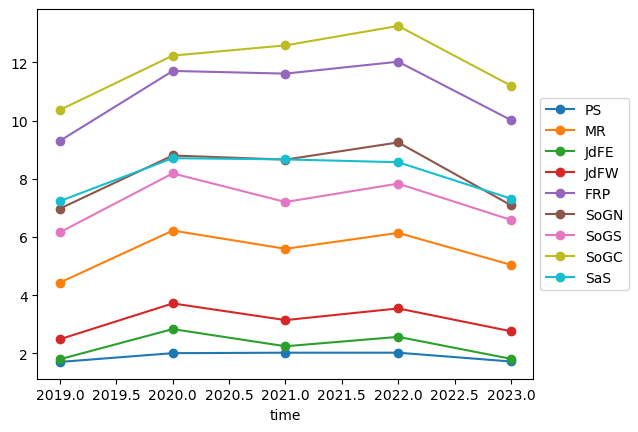

In [33]:
meters_df = meters_ds.to_dataframe()
max_meters = meters_df.groupby(meters_df.index.year)[regions_list].max()

for idx in np.arange(len(regions_list)):
    region = regions_list[idx]
    max_meters[region].plot(marker='o', label=region, color=tablist_nogrey[idx])
# meters_df['time'] = meters_df['time'].dt.strftime('%m-%d-%Y')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [34]:
max_meters_day = meters_df.groupby(meters_df.index.year)[regions_list].idxmax()

In [35]:
def to_month_day(dt):
    return datetime(1900, dt.month, dt.day)
max_attributes = pd.merge(max_meters_day.reset_index().melt(id_vars='time', var_name='region', value_name='datetime'), max_meters.reset_index().melt(id_vars='time', var_name='region', value_name='max [m^3]')).rename(columns={'time': 'year'})
max_attributes['day1900'] = max_attributes['datetime'].apply(to_month_day)
max_attributes['day'] = max_attributes['day1900'].dt.strftime('%m-%d')
max_attributes.head()

,year,region,datetime,max [m^3],day1900,day
0,2019,PS,2019-09-05 12:00:00,1.705280,1900-09-05,09-05
1,2020,PS,2020-09-05 12:00:00,2.006430,1900-09-05,09-05
2,2021,PS,2021-08-26 12:00:00,2.022201,1900-08-26,08-26
3,2022,PS,2022-09-14 12:00:00,2.022120,1900-09-14,09-14
4,2023,PS,2023-01-01 12:00:00,1.720061,1900-01-01,01-01


In [36]:
def plot_max_date_and_value(year_of_interest, ax):
    palette = tablist_nogrey
    markers = ['X', 's', 'D', '^', 'h']

    for i, year in enumerate(max_attributes['year'].unique()):
            if year == year_of_interest:
                   alpha_val = 0.95
            else:
                   alpha_val = 0.4
            for j, region in enumerate(max_attributes['region'].unique()):
                    df_year = max_attributes[(max_attributes['year'] == year) & (max_attributes['region'] == region)]
                    ax.scatter(data=df_year, x='day1900', y='max [m^3]', c=tablist_nogrey[j], marker=markers[i], s=80, edgecolors='k', alpha=alpha_val)
#     plt.xticks(rotation=45)
    date_format = DateFormatter('%b')
    plt.gca().xaxis.set_major_formatter(date_format)
    ax.set_xlabel='date'

    custom_lines = [
        plt.Line2D([0], [0], color='k', lw=0, linestyle='-', marker=markers[0]),
        plt.Line2D([0], [0], color='k', lw=0, linestyle='-', marker=markers[1]),
        plt.Line2D([0], [0], color='k', lw=0, linestyle='-', marker=markers[2]),
        plt.Line2D([0], [0], color='k', lw=0, linestyle='-', marker=markers[3]),
        plt.Line2D([0], [0], color='k', lw=0, linestyle='-', marker=markers[4]),
        plt.Line2D([0], [0], color=tablist_nogrey[0], lw=0, linestyle='-', marker='o'),
        plt.Line2D([0], [0], color=tablist_nogrey[1], lw=0, linestyle='-', marker='o'),
        plt.Line2D([0], [0], color=tablist_nogrey[2], lw=0, linestyle='-', marker='o'),
        plt.Line2D([0], [0], color=tablist_nogrey[3], lw=0, linestyle='-', marker='o'),
        plt.Line2D([0], [0], color=tablist_nogrey[4], lw=0, linestyle='-', marker='o'),
        plt.Line2D([0], [0], color=tablist_nogrey[5], lw=0, linestyle='-', marker='o'),
        plt.Line2D([0], [0], color=tablist_nogrey[6], lw=0, linestyle='-', marker='o'),
        plt.Line2D([0], [0], color=tablist_nogrey[7], lw=0, linestyle='-', marker='o'),
        plt.Line2D([0], [0], color=tablist_nogrey[8], lw=0, linestyle='-', marker='o')
    ]
    # plt.legend(custom_lines, list(max_attributes['year'].unique())+list(max_attributes['region'].unique()), loc='center left', bbox_to_anchor=(1, 0.5))

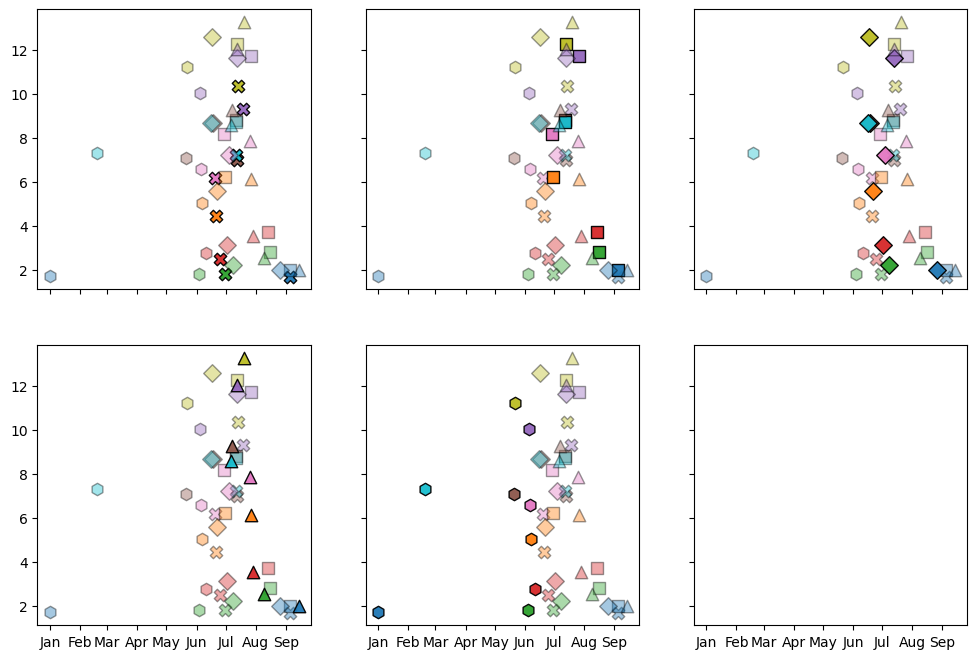

In [37]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=True)
plot_max_date_and_value(2019, ax[0,0])
plot_max_date_and_value(2020, ax[0,1])
plot_max_date_and_value(2021, ax[0,2])
plot_max_date_and_value(2022, ax[1,0])
plot_max_date_and_value(2023, ax[1,1])

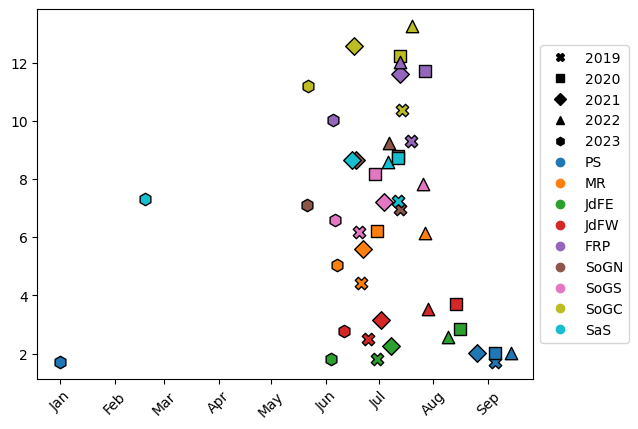

In [38]:
palette = tablist_nogrey
markers = ['X', 's', 'D', '^', 'h']

for i, year in enumerate(max_attributes['year'].unique()):
        for j, region in enumerate(max_attributes['region'].unique()):
                df_year = max_attributes[(max_attributes['year'] == year) & (max_attributes['region'] == region)]
                plt.scatter(data=df_year, x='day1900', y='max [m^3]', c=tablist_nogrey[j], marker=markers[i], s=80, edgecolors='k')
plt.xticks(rotation=45)
date_format = DateFormatter('%b')
plt.gca().xaxis.set_major_formatter(date_format)
plt.xlabel='date'

custom_lines = [
    plt.Line2D([0], [0], color='k', lw=0, linestyle='-', marker=markers[0]),
    plt.Line2D([0], [0], color='k', lw=0, linestyle='-', marker=markers[1]),
    plt.Line2D([0], [0], color='k', lw=0, linestyle='-', marker=markers[2]),
    plt.Line2D([0], [0], color='k', lw=0, linestyle='-', marker=markers[3]),
    plt.Line2D([0], [0], color='k', lw=0, linestyle='-', marker=markers[4]),
    plt.Line2D([0], [0], color=tablist_nogrey[0], lw=0, linestyle='-', marker='o'),
    plt.Line2D([0], [0], color=tablist_nogrey[1], lw=0, linestyle='-', marker='o'),
    plt.Line2D([0], [0], color=tablist_nogrey[2], lw=0, linestyle='-', marker='o'),
    plt.Line2D([0], [0], color=tablist_nogrey[3], lw=0, linestyle='-', marker='o'),
    plt.Line2D([0], [0], color=tablist_nogrey[4], lw=0, linestyle='-', marker='o'),
    plt.Line2D([0], [0], color=tablist_nogrey[5], lw=0, linestyle='-', marker='o'),
    plt.Line2D([0], [0], color=tablist_nogrey[6], lw=0, linestyle='-', marker='o'),
    plt.Line2D([0], [0], color=tablist_nogrey[7], lw=0, linestyle='-', marker='o'),
    plt.Line2D([0], [0], color=tablist_nogrey[8], lw=0, linestyle='-', marker='o')
]
plt.legend(custom_lines, list(max_attributes['year'].unique())+list(max_attributes['region'].unique()), loc='center left', bbox_to_anchor=(1, 0.5))

## Minumum Values

In [39]:
yearly_min = pd.DataFrame

for year in list(['2019', '2020', '2021', '2022', '2023']):
    meters_year = meters_ds.sel(time=slice('01-15-{}'.format(year), '12-15-{}'.format(year)))
    min_values = {var: meters_year[var].min().item() for var in meters_year.data_vars}
    print(min_values)

{'PS': 1.4135468977010113, 'MR': 2.347555591970209, 'JdFE': 0.8160684264264562, 'JdFW': 1.3201188022313668, 'FRP': 6.899536319267892, 'SoGN': 5.63373691947638, 'SoGS': 3.633235508601832, 'SoGC': 8.62724307198545, 'SaS': 6.344681491916522}
{'PS': 1.3881038325724042, 'MR': 2.4856100343767014, 'JdFE': 0.801682258831452, 'JdFW': 1.366413390184657, 'FRP': 7.475536933019698, 'SoGN': 6.206026425168826, 'SoGS': 3.775380876427819, 'SoGC': 9.301764471693444, 'SaS': 6.7489075337235045}
{'PS': 1.650536203904424, 'MR': 2.607042141516354, 'JdFE': 0.9996670376770133, 'JdFW': 1.6479818469345289, 'FRP': 7.747472609373415, 'SoGN': 6.694107832660761, 'SoGS': 3.856352614278631, 'SoGC': 10.264399825628466, 'SaS': 7.194667278796997}
{'PS': 1.5312645960347298, 'MR': 2.4333224918294762, 'JdFE': 0.9288283550078434, 'JdFW': 1.4684959392082624, 'FRP': 7.351494483918579, 'SoGN': 6.499207908606455, 'SoGS': 3.665244504621328, 'SoGC': 9.624619645262687, 'SaS': 7.198387541290613}
{'PS': 1.413168951223184, 'MR': 2.223

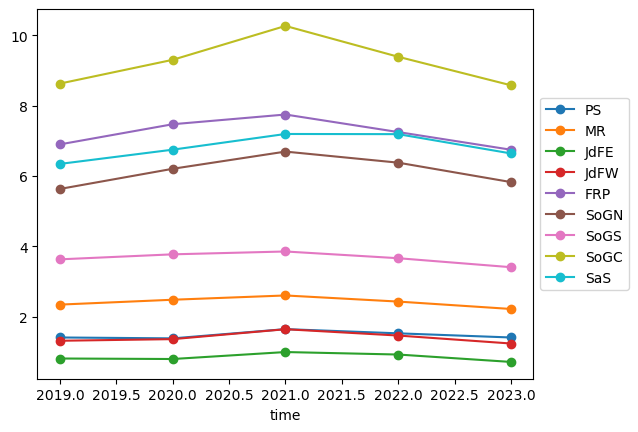

In [40]:
meters_df = meters_ds.to_dataframe()
min_meters = meters_df.groupby(meters_df.index.year)[regions_list].min()

for idx in np.arange(len(regions_list)):
    region = regions_list[idx]
    min_meters[region].plot(marker='o', label=region, color=tablist_nogrey[idx])
# meters_df['time'] = meters_df['time'].dt.strftime('%m-%d-%Y')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [41]:
min_meters_day = meters_df.groupby(meters_df.index.year)[regions_list].idxmin()

In [42]:
def to_month_day(dt):
    return datetime(1900, dt.month, dt.day)
min_attributes = pd.merge(min_meters_day.reset_index().melt(id_vars='time', var_name='region', value_name='datetime'), min_meters.reset_index().melt(id_vars='time', var_name='region', value_name='min [m^3]')).rename(columns={'time': 'year'})
min_attributes['day1900'] = min_attributes['datetime'].apply(to_month_day)
min_attributes['day'] = min_attributes['day1900'].dt.strftime('%m-%d')
min_attributes.head()

,year,region,datetime,min [m^3],day1900,day
0,2019,PS,2019-05-02 12:00:00,1.413547,1900-05-02,05-02
1,2020,PS,2020-05-19 12:00:00,1.388104,1900-05-19,05-19
2,2021,PS,2021-05-13 12:00:00,1.650536,1900-05-13,05-13
3,2022,PS,2022-06-11 12:00:00,1.531265,1900-06-11,06-11
4,2023,PS,2023-05-29 12:00:00,1.413169,1900-05-29,05-29


In [43]:
def plot_min_date_and_value(year_of_interest, ax):
    palette = tablist_nogrey
    markers = ['X', 's', 'D', '^', 'h']

    for i, year in enumerate(min_attributes['year'].unique()):
            if year == year_of_interest:
                   alpha_val = 0.95
            else:
                   alpha_val = 0.4
            for j, region in enumerate(min_attributes['region'].unique()):
                    df_year = min_attributes[(min_attributes['year'] == year) & (min_attributes['region'] == region)]
                    ax.scatter(data=df_year, x='day1900', y='min [m^3]', c=tablist_nogrey[j], marker=markers[i], s=80, edgecolors='k', alpha=alpha_val)
#     plt.xticks(rotation=45)
    date_format = DateFormatter('%b')
    plt.gca().xaxis.set_major_formatter(date_format)
    ax.set_xlabel='date'

    custom_lines = [
        plt.Line2D([0], [0], color='k', lw=0, linestyle='-', marker=markers[0]),
        plt.Line2D([0], [0], color='k', lw=0, linestyle='-', marker=markers[1]),
        plt.Line2D([0], [0], color='k', lw=0, linestyle='-', marker=markers[2]),
        plt.Line2D([0], [0], color='k', lw=0, linestyle='-', marker=markers[3]),
        plt.Line2D([0], [0], color='k', lw=0, linestyle='-', marker=markers[4]),
        plt.Line2D([0], [0], color=tablist_nogrey[0], lw=0, linestyle='-', marker='o'),
        plt.Line2D([0], [0], color=tablist_nogrey[1], lw=0, linestyle='-', marker='o'),
        plt.Line2D([0], [0], color=tablist_nogrey[2], lw=0, linestyle='-', marker='o'),
        plt.Line2D([0], [0], color=tablist_nogrey[3], lw=0, linestyle='-', marker='o'),
        plt.Line2D([0], [0], color=tablist_nogrey[4], lw=0, linestyle='-', marker='o'),
        plt.Line2D([0], [0], color=tablist_nogrey[5], lw=0, linestyle='-', marker='o'),
        plt.Line2D([0], [0], color=tablist_nogrey[6], lw=0, linestyle='-', marker='o'),
        plt.Line2D([0], [0], color=tablist_nogrey[7], lw=0, linestyle='-', marker='o'),
        plt.Line2D([0], [0], color=tablist_nogrey[8], lw=0, linestyle='-', marker='o')
    ]
    # plt.legend(custom_lines, list(min_attributes['year'].unique())+list(min_attributes['region'].unique()), loc='center left', bbox_to_anchor=(1, 0.5))

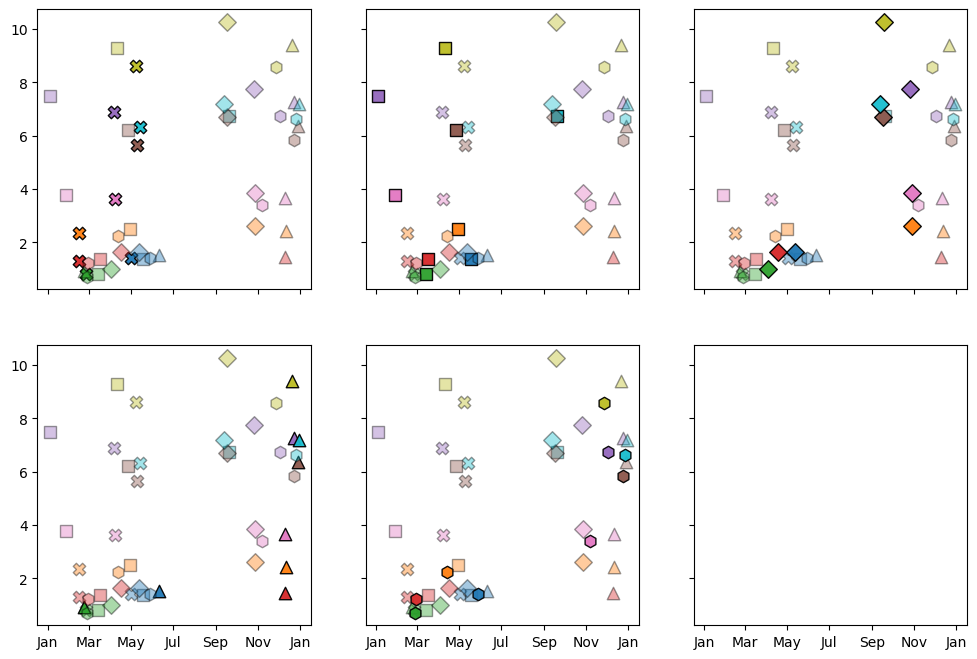

In [44]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=True)
plot_min_date_and_value(2019, ax[0,0])
plot_min_date_and_value(2020, ax[0,1])
plot_min_date_and_value(2021, ax[0,2])
plot_min_date_and_value(2022, ax[1,0])
plot_min_date_and_value(2023, ax[1,1])

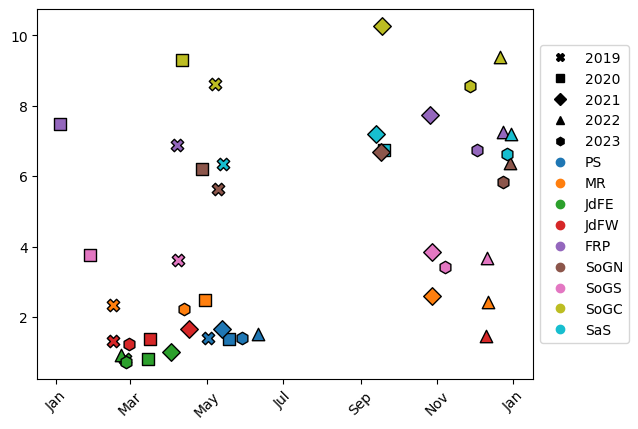

In [45]:
palette = tablist_nogrey
markers = ['X', 's', 'D', '^', 'h']

for i, year in enumerate(min_attributes['year'].unique()):
        for j, region in enumerate(min_attributes['region'].unique()):
                df_year = min_attributes[(min_attributes['year'] == year) & (min_attributes['region'] == region)]
                plt.scatter(data=df_year, x='day1900', y='min [m^3]', c=tablist_nogrey[j], marker=markers[i], s=80, edgecolors='k')
plt.xticks(rotation=45)
date_format = DateFormatter('%b')
plt.gca().xaxis.set_major_formatter(date_format)
plt.xlabel='date'

custom_lines = [
    plt.Line2D([0], [0], color='k', lw=0, linestyle='-', marker=markers[0]),
    plt.Line2D([0], [0], color='k', lw=0, linestyle='-', marker=markers[1]),
    plt.Line2D([0], [0], color='k', lw=0, linestyle='-', marker=markers[2]),
    plt.Line2D([0], [0], color='k', lw=0, linestyle='-', marker=markers[3]),
    plt.Line2D([0], [0], color='k', lw=0, linestyle='-', marker=markers[4]),
    plt.Line2D([0], [0], color=tablist_nogrey[0], lw=0, linestyle='-', marker='o'),
    plt.Line2D([0], [0], color=tablist_nogrey[1], lw=0, linestyle='-', marker='o'),
    plt.Line2D([0], [0], color=tablist_nogrey[2], lw=0, linestyle='-', marker='o'),
    plt.Line2D([0], [0], color=tablist_nogrey[3], lw=0, linestyle='-', marker='o'),
    plt.Line2D([0], [0], color=tablist_nogrey[4], lw=0, linestyle='-', marker='o'),
    plt.Line2D([0], [0], color=tablist_nogrey[5], lw=0, linestyle='-', marker='o'),
    plt.Line2D([0], [0], color=tablist_nogrey[6], lw=0, linestyle='-', marker='o'),
    plt.Line2D([0], [0], color=tablist_nogrey[7], lw=0, linestyle='-', marker='o'),
    plt.Line2D([0], [0], color=tablist_nogrey[8], lw=0, linestyle='-', marker='o')
]
plt.legend(custom_lines, list(min_attributes['year'].unique())+list(min_attributes['region'].unique()), loc='center left', bbox_to_anchor=(1, 0.5))

## Peak Width

In [46]:
plus_none = max_meters_day[max_meters_day.index == 2022]['PS']
plus_15 = plus_none + pd.DateOffset(days=15)
plus_15 = str(plus_15.iloc[0])
minu_15 = plus_none - pd.DateOffset(days=15)
minu_15 = str(minu_15.iloc[0])


meters_ds['PS'].sel(time=slice(minu_15, plus_15))

<xarray.DataArray 'PS' (time: 31)>
array([1.991318, 1.994222, 1.996247, 1.997036, 1.997301, 1.997324, 1.998022,
       1.999825, 2.002346, 2.004231, 2.007595, 2.01174 , 2.01549 , 2.018489,
       2.020939, 2.02212 , 2.021769, 2.021587, 2.020908, 2.019823, 2.017478,
       2.013926, 2.010711, 2.008661, 2.007016, 2.006578, 2.006937, 2.008155,
       2.009649, 2.011338, 2.01221 ])
Coordinates:
  * time     (time) datetime64[ns] 2022-08-30T12:00:00 ... 2022-09-29T12:00:00

I think I sould go back to what I thought before of looking for the halfway point between the maximum and the minumum? Also, I need to fix the January 2023 one... This is maybe happening in the ones that have a large time shift in them? I could try to find the local maxima instead of global for the timeseries

## Stuff

In [47]:
# total_area = make_1d(area, PS_all)

In [48]:
# dim1_2019_mon = make_1d(sum_2019_mon, PS_all)  # dim1 is the sum of all the water in the given regions. is 1d in time for each river
# dim1_2020_mon = make_1d(sum_2020_mon, PS_all)
# dim1_2021_mon = make_1d(sum_2021_mon, PS_all)
# dim1_2022_mon = make_1d(sum_2022_mon, PS_all)
# dim1_2023_mon = make_1d(sum_2023_mon, PS_all)
# dim1_all_mon = xr.concat([dim1_2019_mon, dim1_2020_mon, dim1_2021_mon, dim1_2022_mon, dim1_2023_mon], dim='time')

In [49]:
# meters1_2019_mon = dim1_2019_mon/total_area  # meters1 is the sum of all the water in the region divided by the total area of the regions. is 1d in time for each river
# meters1_2020_mon = dim1_2020_mon/total_area
# meters1_2021_mon = dim1_2021_mon/total_area
# meters1_2022_mon = dim1_2022_mon/total_area
# meters1_2023_mon = dim1_2023_mon/total_area
# meters1_all_mon = xr.concat([meters1_2019_mon, meters1_2020_mon, meters1_2021_mon, meters1_2022_mon, meters1_2023_mon], dim='time')

In [50]:
# totals_2019_mon = dim1_2019_mon.to_array().sum(dim="variable")  # totals is the sum of all freshwater in the region from all the rivers. 1d in time and not sep by river
# totals_2020_mon = dim1_2020_mon.to_array().sum(dim="variable")
# totals_2021_mon = dim1_2021_mon.to_array().sum(dim="variable")
# totals_2022_mon = dim1_2022_mon.to_array().sum(dim="variable")
# totals_2023_mon = dim1_2023_mon.to_array().sum(dim="variable")
# totals_all_mon = xr.concat([totals_2019_mon, totals_2020_mon, totals_2021_mon, totals_2022_mon, totals_2023_mon], dim='time')

In [51]:
# prop_2019_mon = dim1_2019_mon/totals_2019_mon  # prop is the dim1 volume of fw divided by all freshwater, for each river, giving pct contribution of freshwater! 1d in time for each river
# prop_2020_mon = dim1_2020_mon/totals_2020_mon
# prop_2021_mon = dim1_2021_mon/totals_2021_mon
# prop_2022_mon = dim1_2022_mon/totals_2022_mon
# prop_2023_mon = dim1_2023_mon/totals_2023_mon
# prop_all_mon = xr.concat([prop_2019_mon, prop_2020_mon, prop_2021_mon, prop_2022_mon, prop_2023_mon], dim='time')

In [52]:
this_p_var = 'fraser_river'

sum_monthly_mean = np.mean([sum_2019_mon[this_p_var], sum_2020_mon[this_p_var], sum_2021_mon[this_p_var], sum_2022_mon[this_p_var], sum_2023_mon[this_p_var]], axis=0)
sum_5year_mean = np.mean(sum_monthly_mean, axis=0)

In [53]:
sum_monthly_mean.shape

(12, 898, 398)

## Full Field View

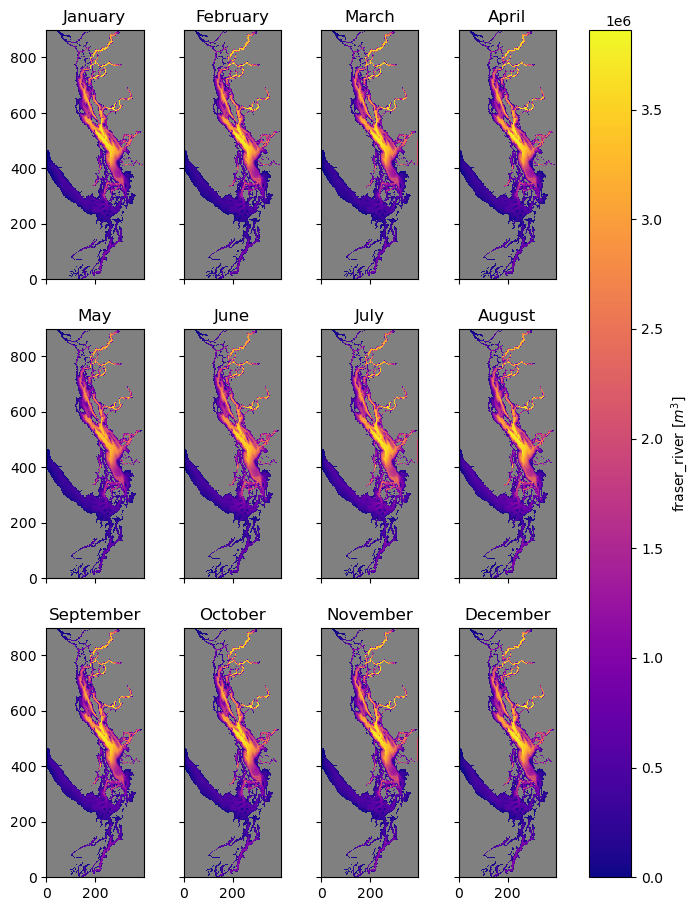

In [54]:
# array = sum_monthly_mean
cmap = mpl.colormaps['plasma']
nrow = 3
ncol = 4
fudge = 0.001

# fname = '{}_all_domain_subset_daily_sum_y{}'.format(p_var, year)
cmap.set_bad('gray')

fig, ax = plt.subplots(nrow,ncol, figsize = (8.5, 11), sharex=True, sharey=True)

for row in np.arange(nrow):
    for col in np.arange(ncol):
        time_idx = row * ncol + col
        salinity = np.ma.masked_array(sum_monthly_mean[time_idx], mask=tmask[0])
        colours = ax[row,col].pcolormesh(salinity, vmin=0, cmap=cmap)
        # colours = ax[row,col].pcolormesh(salinity, norm=colors.LogNorm(vmin=fudge), cmap=cmap)
        dtime = pd.to_datetime(sum_2019_mon['time'].values[time_idx])
        ax[row,col].set_title('{}'.format(dtime.month_name()))
        viz_tools.set_aspect(ax[row,col]);

cb = fig.colorbar(colours, ax=ax, label=r'{} [$m^3$]'.format(this_p_var))

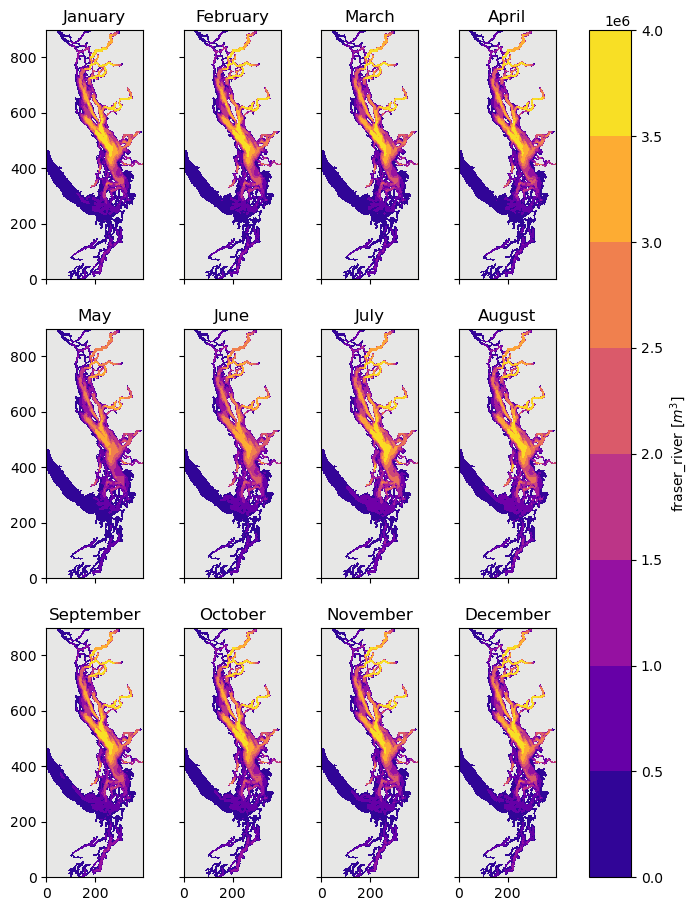

In [55]:
# array = sum_monthly_mean
cmap = mpl.colormaps['plasma']
nrow = 3
ncol = 4
fudge = 0.001

# fname = '{}_all_domain_subset_daily_sum_y{}'.format(p_var, year)
cmap.set_bad('gray')

fig, ax = plt.subplots(nrow,ncol, figsize = (8.5, 11), sharex=True, sharey=True)

for row in np.arange(nrow):
    for col in np.arange(ncol):
        time_idx = row * ncol + col
        fw_vol = np.ma.masked_array(sum_monthly_mean[time_idx], mask=tmask[0])
        ax[row,col].contourf(tmask[0], vmin=0, cmap=cm.gray)
        colours = ax[row,col].contourf(fw_vol, vmin=0, cmap=cmap)
        # colours = ax[row,col].pcolormesh(fw_vol, norm=colors.LogNorm(vmin=fudge), cmap=cmap)
        dtime = pd.to_datetime(sum_2019_mon['time'].values[time_idx])
        ax[row,col].set_title('{}'.format(dtime.month_name()))
        viz_tools.set_aspect(ax[row,col]);

cb = fig.colorbar(colours, ax=ax, label=r'{} [$m^3$]'.format(this_p_var))